In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_pickle('data/processed/training_ffill_bfill_zeros.pickle')
for idx, patient_data in enumerate(dataset):
    if idx == 971:
        break

In [3]:
def platelets_sofa(platelets):
    s_score = 0
    if platelets > 150:
        s_score += 0
    elif platelets >= 101 and platelets <= 150:
        s_score += 1
    elif platelets >= 51 and platelets <= 100:
        s_score += 2
    elif platelets >= 21 and platelets <= 50:
        s_score += 3
    elif platelets <= 20:
        s_score += 4
        
    return s_score

patient_data['Platelets_SOFA'] = patient_data['Platelets'].apply(platelets_sofa)

In [4]:
def total_bilirubin_sofa(bilirubin):
    s_score = 0
    if bilirubin < 1.2:
        s_score += 0
    elif bilirubin >= 1.2 and bilirubin <= 1.9:
        s_score += 1
    elif bilirubin >= 2.0 and bilirubin <= 5.9:
        s_score += 2
    elif bilirubin >= 6 and bilirubin <= 11.9:
        s_score += 3
    elif bilirubin >= 12.0:
        s_score += 4
        
    return s_score

patient_data['Bilirubin_total_SOFA'] = patient_data['Bilirubin_total'].apply(total_bilirubin_sofa)

In [5]:
def map_sofa(map):
    s_score = 0
    if map >= 70:
        s_score += 0
    elif map < 70:
        s_score += 1
        
    return s_score

patient_data['MAP_SOFA'] = patient_data['MAP'].apply(map_sofa)

In [6]:
def sofa_score(row):
    platelets_score = row['Platelets_SOFA']
    bilirubin_score = row['Bilirubin_total_SOFA']
    map_sofa = row['MAP_SOFA']
        
    return platelets_score + bilirubin_score + map_sofa

patient_data['SOFA_score'] = patient_data.apply(sofa_score, axis=1)

In [7]:
def detect_sofa_deterioration(data, time_window=24):
    data['SOFA_score_diff'] = data['SOFA_score'].diff(periods=time_window)
    data['SOFA_deterioration'] = (abs(data['SOFA_score_diff']) >= 2).astype(int)  # 2-point deterioration
    data['SOFA_score_diff'].fillna(value=0, inplace=True)
    return data

patient_data = detect_sofa_deterioration(patient_data)

In [8]:
def sofa_indicator(row):
    # 2+ points indicates organ dysfunction
    platelets = row['Platelets_SOFA']
    bilirubin_total = row['Bilirubin_total_SOFA']
    map = row['MAP_SOFA']
    
    total_points = platelets + bilirubin_total + map
    
    q_score = 0
    if total_points > 2:
        q_score += 1
    return q_score

patient_data['SOFA_indicator'] = patient_data.apply(sofa_indicator, axis=1)

In [9]:
patient_data

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,ICULOS,SepsisLabel,PatientID,Platelets_SOFA,Bilirubin_total_SOFA,MAP_SOFA,SOFA_score,SOFA_score_diff,SOFA_deterioration,SOFA_indicator
0,104.5,96.5,37.11,95.0,56.0,0.0,32.0,0.0,10.0,34.0,...,1,0,971,0,0,1,1.0,0.0,0,0
1,104.5,96.5,37.11,95.0,56.0,0.0,32.0,0.0,10.0,34.0,...,2,0,971,0,0,1,1.0,0.0,0,0
2,109.0,98.0,37.11,102.0,61.0,0.0,33.0,0.0,10.0,34.0,...,3,0,971,0,0,1,1.0,0.0,0,0
3,109.0,98.0,37.11,102.0,61.0,0.0,33.0,0.0,10.0,34.0,...,4,0,971,0,0,1,1.0,0.0,0,0
4,104.0,99.0,36.33,109.0,66.0,0.0,38.0,0.0,10.0,34.0,...,5,0,971,0,0,1,1.0,0.0,0,0
5,91.0,92.5,36.33,89.0,59.0,0.0,29.0,0.0,10.0,34.0,...,6,0,971,0,0,1,1.0,0.0,0,0
6,79.0,92.0,36.33,93.0,55.0,0.0,28.0,0.0,10.0,34.0,...,7,0,971,0,0,1,1.0,0.0,0,0
7,88.0,91.0,36.33,104.0,62.0,0.0,34.0,0.0,10.0,34.0,...,8,0,971,0,0,1,1.0,0.0,0,0
8,83.0,92.5,37.33,103.0,62.5,0.0,29.0,0.0,10.0,34.0,...,9,1,971,0,0,1,1.0,0.0,0,0
9,82.0,89.0,37.33,115.0,70.0,0.0,34.0,0.0,10.0,34.0,...,10,1,971,0,0,0,0.0,0.0,0,0


In [10]:
def respiratory_rate_qsofa(respiratory_rate):
    q_score = 0
    if respiratory_rate >= 22.0:
        q_score += 1
        
    return q_score

patient_data['ResP_qSOFA'] = patient_data['Resp'].apply(respiratory_rate_qsofa)

In [11]:
def sbp_qsofa(sbp):
    q_score = 0
    if sbp < 100.0:
        q_score += 1
        
    return q_score

patient_data['SBP_qSOFA'] = patient_data['SBP'].apply(sbp_qsofa)

In [12]:
def q_sofa_indicator(row):
    resp = row['ResP_qSOFA']
    sbp = row['SBP_qSOFA']
    q_score = 0
    if resp > 0 and sbp > 0:
        q_score += 1
    return q_score

patient_data['qSOFA_indicator'] = patient_data.apply(q_sofa_indicator, axis=1)

In [13]:
def qsofa_score(row):
    resp_score = row['ResP_qSOFA']
    sbp_score = row['SBP_qSOFA']
        
    return sbp_score + resp_score

patient_data['qSOFA_score'] = patient_data.apply(qsofa_score, axis=1)

In [14]:
def detect_qsofa_change(data, time_window=24):
    data['qSOFA_score_diff'] = data['qSOFA_score'].diff(periods=time_window)
    data['qSOFA_deterioration'] = (abs(data['qSOFA_score_diff']) >= 2).astype(int)  # 2-point deterioration
    data['qSOFA_score_diff'].fillna(value=0, inplace=True)
    
    return data

patient_data = detect_qsofa_change(patient_data)

In [15]:
patient_data

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,SOFA_score,SOFA_score_diff,SOFA_deterioration,SOFA_indicator,ResP_qSOFA,SBP_qSOFA,qSOFA_indicator,qSOFA_score,qSOFA_score_diff,qSOFA_deterioration
0,104.5,96.5,37.11,95.0,56.0,0.0,32.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,1,1,2.0,0.0,0
1,104.5,96.5,37.11,95.0,56.0,0.0,32.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,1,1,2.0,0.0,0
2,109.0,98.0,37.11,102.0,61.0,0.0,33.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,0,0,1.0,0.0,0
3,109.0,98.0,37.11,102.0,61.0,0.0,33.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,0,0,1.0,0.0,0
4,104.0,99.0,36.33,109.0,66.0,0.0,38.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,0,0,1.0,0.0,0
5,91.0,92.5,36.33,89.0,59.0,0.0,29.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,1,1,2.0,0.0,0
6,79.0,92.0,36.33,93.0,55.0,0.0,28.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,1,1,2.0,0.0,0
7,88.0,91.0,36.33,104.0,62.0,0.0,34.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,0,0,1.0,0.0,0
8,83.0,92.5,37.33,103.0,62.5,0.0,29.0,0.0,10.0,34.0,...,1.0,0.0,0,0,1,0,0,1.0,0.0,0
9,82.0,89.0,37.33,115.0,70.0,0.0,34.0,0.0,10.0,34.0,...,0.0,0.0,0,0,1,0,0,1.0,0.0,0


In [16]:
def mortality_sofa(row):
    # 2+ points indicates organ dysfunction
    platelets = row['Platelets_SOFA']
    bilirubin_total = row['Bilirubin_total_SOFA']
    map = row['MAP_SOFA']
    
    total_points = platelets + bilirubin_total + map
    
    mortality_rate = 0
    if total_points > 1 and total_points <= 9:
        mortality_rate += 0.30
    elif total_points >= 10 and total_points < 14:
        mortality_rate += 0.50
    elif total_points >= 14:
        mortality_rate += 0.95
        
    return mortality_rate

patient_data['Mortality_sofa'] = patient_data.apply(mortality_sofa, axis=1)

In [17]:
patient_data

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,SOFA_score_diff,SOFA_deterioration,SOFA_indicator,ResP_qSOFA,SBP_qSOFA,qSOFA_indicator,qSOFA_score,qSOFA_score_diff,qSOFA_deterioration,Mortality_sofa
0,104.5,96.5,37.11,95.0,56.0,0.0,32.0,0.0,10.0,34.0,...,0.0,0,0,1,1,1,2.0,0.0,0,0
1,104.5,96.5,37.11,95.0,56.0,0.0,32.0,0.0,10.0,34.0,...,0.0,0,0,1,1,1,2.0,0.0,0,0
2,109.0,98.0,37.11,102.0,61.0,0.0,33.0,0.0,10.0,34.0,...,0.0,0,0,1,0,0,1.0,0.0,0,0
3,109.0,98.0,37.11,102.0,61.0,0.0,33.0,0.0,10.0,34.0,...,0.0,0,0,1,0,0,1.0,0.0,0,0
4,104.0,99.0,36.33,109.0,66.0,0.0,38.0,0.0,10.0,34.0,...,0.0,0,0,1,0,0,1.0,0.0,0,0
5,91.0,92.5,36.33,89.0,59.0,0.0,29.0,0.0,10.0,34.0,...,0.0,0,0,1,1,1,2.0,0.0,0,0
6,79.0,92.0,36.33,93.0,55.0,0.0,28.0,0.0,10.0,34.0,...,0.0,0,0,1,1,1,2.0,0.0,0,0
7,88.0,91.0,36.33,104.0,62.0,0.0,34.0,0.0,10.0,34.0,...,0.0,0,0,1,0,0,1.0,0.0,0,0
8,83.0,92.5,37.33,103.0,62.5,0.0,29.0,0.0,10.0,34.0,...,0.0,0,0,1,0,0,1.0,0.0,0,0
9,82.0,89.0,37.33,115.0,70.0,0.0,34.0,0.0,10.0,34.0,...,0.0,0,0,1,0,0,1.0,0.0,0,0


In [18]:
def temp_sirs(temp):
    sirs_score = 0
    if temp < 36 or temp >= 38:
        sirs_score += 1
        
    return sirs_score

patient_data['Temp_sirs'] = patient_data['Temp'].apply(temp_sirs)

In [19]:
def heart_rate_sirs(heart_rate):
    sirs_score = 0
    if heart_rate > 90:
        sirs_score += 1
        
    return sirs_score

patient_data['HR_sirs'] = patient_data['HR'].apply(heart_rate_sirs)

In [20]:
def resp_sirs(resp):
    sirs_score = 0
    if resp > 20:
        sirs_score += 1
        
    return sirs_score

patient_data['Resp_sirs'] = patient_data['Resp'].apply(resp_sirs)

In [21]:
def paco2_sirs(paco2):
    sirs_score = 0
    if paco2 < 32:
        sirs_score += 1
        
    return sirs_score

patient_data['paco2_sirs'] = patient_data['PaCO2'].apply(resp_sirs)

In [22]:
def wbc_sirs(wbc):
    sirs_score = 0
    if wbc*1000 < 4000 or wbc*1000 > 12000:
        sirs_score += 1
    return sirs_score

patient_data['wbc_sirs'] = patient_data['WBC'].apply(wbc_sirs)

In [23]:
patient_data

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,qSOFA_indicator,qSOFA_score,qSOFA_score_diff,qSOFA_deterioration,Mortality_sofa,Temp_sirs,HR_sirs,Resp_sirs,paco2_sirs,wbc_sirs
0,104.5,96.5,37.11,95.0,56.0,0.0,32.0,0.0,10.0,34.0,...,1,2.0,0.0,0,0,0,1,1,1,0
1,104.5,96.5,37.11,95.0,56.0,0.0,32.0,0.0,10.0,34.0,...,1,2.0,0.0,0,0,0,1,1,1,0
2,109.0,98.0,37.11,102.0,61.0,0.0,33.0,0.0,10.0,34.0,...,0,1.0,0.0,0,0,0,1,1,1,0
3,109.0,98.0,37.11,102.0,61.0,0.0,33.0,0.0,10.0,34.0,...,0,1.0,0.0,0,0,0,1,1,1,0
4,104.0,99.0,36.33,109.0,66.0,0.0,38.0,0.0,10.0,34.0,...,0,1.0,0.0,0,0,0,1,1,1,0
5,91.0,92.5,36.33,89.0,59.0,0.0,29.0,0.0,10.0,34.0,...,1,2.0,0.0,0,0,0,1,1,1,0
6,79.0,92.0,36.33,93.0,55.0,0.0,28.0,0.0,10.0,34.0,...,1,2.0,0.0,0,0,0,0,1,1,0
7,88.0,91.0,36.33,104.0,62.0,0.0,34.0,0.0,10.0,34.0,...,0,1.0,0.0,0,0,0,0,1,1,0
8,83.0,92.5,37.33,103.0,62.5,0.0,29.0,0.0,10.0,34.0,...,0,1.0,0.0,0,0,0,0,1,1,0
9,82.0,89.0,37.33,115.0,70.0,0.0,34.0,0.0,10.0,34.0,...,0,1.0,0.0,0,0,0,0,1,1,0


In [24]:
def t_suspicion(patient_data):
    """
    Since we don't have information about IV antibiotics and blood cultures, 
    we are is considering that patient have infection if any 2 SIRS criteria are met
    """
    patient_data['infection_proxy'] = (patient_data[['Temp_sirs', 'HR_sirs', 'Resp_sirs']].eq(1).sum(axis=1) >= 2).astype(int)

    # t_suspicion is the first hour of (ICULOS) where infection proxy is positive at time t
    patient_data['t_suspicion'] = patient_data.groupby(['PatientID'])['ICULOS'].transform(
        lambda x: x[patient_data['infection_proxy'] == 1].min() if (patient_data['infection_proxy'] == 1).any() else 0)

    return patient_data

def t_sofa(data):
    """
    Two-point deterioration in SOFA score at time t but within a 24-hour period.
    """
    data['t_sofa'] = data['SOFA_score_diff'].where((abs(data['SOFA_score_diff']) >= 2) & (data['ICULOS'] <= 24), other=0)
    return data

def t_sepsis(row):
    if pd.isna(row['t_suspicion']) or row['t_suspicion'] == 0 or row['t_sofa'] == 0:
        return 0
    if row['t_suspicion'] - 24 <= row['t_sofa'] <= row['t_suspicion'] + 12:
        return min(row['t_suspicion'], row['t_sofa'])

patient_data = t_suspicion(patient_data)
patient_data = t_sofa(patient_data)
patient_data['t_sepsis'] = patient_data.apply(t_sepsis, axis=1)

In [25]:
patient_data[['SepsisLabel', 'ICULOS', 'SOFA_score', 'SOFA_score_diff', 't_suspicion', 't_sofa', 't_sepsis']]

,SepsisLabel,ICULOS,SOFA_score,SOFA_score_diff,t_suspicion,t_sofa,t_sepsis
0,0,1,1.0,0.0,1,0.0,0
1,0,2,1.0,0.0,1,0.0,0
2,0,3,1.0,0.0,1,0.0,0
3,0,4,1.0,0.0,1,0.0,0
4,0,5,1.0,0.0,1,0.0,0
5,0,6,1.0,0.0,1,0.0,0
6,0,7,1.0,0.0,1,0.0,0
7,0,8,1.0,0.0,1,0.0,0
8,1,9,1.0,0.0,1,0.0,0
9,1,10,0.0,0.0,1,0.0,0


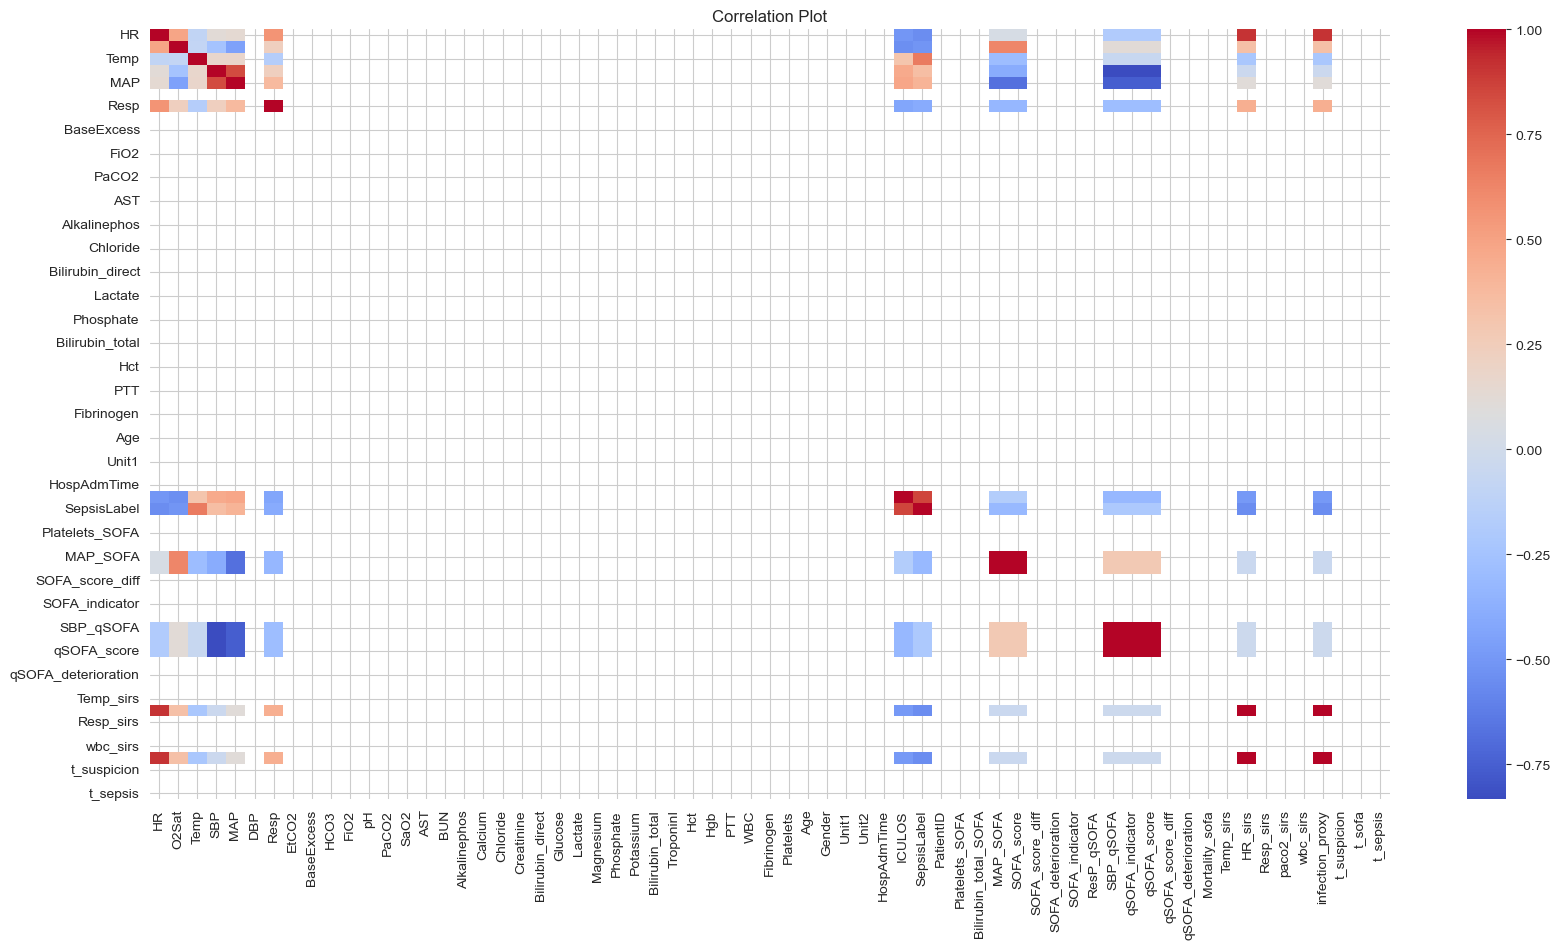

In [26]:
# Calculate point-biserial correlation coefficients
correlation_matrix = patient_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Plot')
plt.show()

In [27]:
-

SyntaxError: invalid syntax (3457752569.py, line 1)

In [ ]:
# PaO2 or oxygen pressure, is the least helpful to answer the question about oxygen adequacy in the blood.
# Note that SaO2 alone doesn't reveal how much oxygen is in the blood; for that we also need to know the hemoglobin content

- **Alternative indices of oxygenation include (https://litfl.com/pao2-fio2-ratio/):**<br>
- **Ratio of SaO2/FiO2**
- 


In [ ]:
# # https://litfl.com/a-a-gradient/
# P_atm, P_h2o = 760, 47  # mmHg, mmHg
# PiO2 = (P_atm - P_h2o) * FiO2  # FiO2 from dataset (percent/fraction)
# PAO2 = PiO2 - (PaCO2 / 0.8)  # PaCO2 from dataset (mmHg)
# 
# PaO2 = 500 * FiO2  # FiO2 from dataset (percent/fraction) [https://litfl.com/pao2-fio2-ratio/]
# print(PAO2, PaO2)

In [ ]:
# Aa_gradient = PAO2 - PaO2  
# print(Aa_gradient)

In [ ]:
# oxygenation_index = (FiO2 * MAP) / PaO2  # FiO2 and MAP from dataset.

In [ ]:
# aA_ratio = PaO2 / PAO2

In [ ]:
# respiratory_index = Aa_gradient / PaO2

In [ ]:
# dataset.columns.sort_values()

In [ ]:
# train_data = pd.read_pickle("data/processed/training_ffill_bfill_zeros.pickle")

In [ ]:
# for idx, p_data in enumerate(train_data):
#     if idx == 8:
#         patient_data = p_data
#         break
#     else:
#         pass

In [ ]:
# def estimate_PaO2(data):
#     """
#     Reference: https://pubmed.ncbi.nlm.nih.gov/31652430/
#     if sepsis == 0, then replace 0's with random percent from 95-99 (normal conditions)
#     if sepsis == 1, then replace 0's with random percent from 90-92 (ill-conditions)
#     """
#     data[data['SaO2']==0]['SaO2'] == 0
#     return (23400/pow(1/data['SaO2'], -0.99))**(1/3)
# 
# def add_oxygenation_features(data):
#     data['sf_ratio'] = data['SaO2']/data['FiO2']
#     
#     # https://litfl.com/a-a-gradient/
#     P_atm, P_h2o = 760, 47  # mmHg, mmHg
#     data['PiO2'] = (P_atm - P_h2o) * data['FiO2']  # FiO2 from dataset (percent/fraction)
#     
#     data['PAO2'] = data['PiO2'] - (data['PaCO2'] / 0.8)  # PaCO2 from dataset (mmHg)
#     # PaO2 = 500 * data['FiO2']  # FiO2 from dataset (percent/fraction) [https://litfl.com/pao2-fio2-ratio/]
#     data['PaO2'] = estimate_PaO2(data)
#      
      # Aa_gradient: Are the lungs transferring oxygen properly from the atmosphere to the pulmonary circulation?
#     data['Aa_gradient'] = data['PAO2'] - data['PAO2'] 
#     data['oxygenation_index'] = (data['FiO2'] * data['MAP']) / data['PaO2']  # FiO2 and MAP from dataset.
#     data['Aa_ratio'] = data['PaO2'] / data['PAO2']
#     data['respiratory_index'] = data['Aa_gradient'] / data['PaO2']
#     
#     data['pf_ratio'] = data['PaO2'] / (data['FiO2'])
#     
#     return data
# 
# temp_data = add_oxygenation_features(patient_data)

In [ ]:
# temp_data

In [ ]:
# temp_data['PaO2'] 

In [ ]:
# def estimate_PaO2(data):
#     """
#     Estimate PaO2 from SaO2 using the modified imputation equation from Gadrey et al. (2019).
#     Reference: https://pubmed.ncbi.nlm.nih.gov/31652430/
#     """
#     
#     SaO2 = data['SaO2']
#     PaO2 = (23400 / ((1 / SaO2) ** -0.99)) ** (1/3)
#     
#     return PaO2
# 
# def add_oxygenation_features(data):
#     # data['SaO2'] = data.apply(lambda row: np.random.uniform(95, 99) if row['SepsisLabel'] == 0 and row['SaO2'] == 0 else row['SaO2'], axis=1)
#     # data['SaO2'] = data.apply(lambda row: np.random.uniform(89, 92) if row['SepsisLabel'] == 1 and row['SaO2'] == 0 else row['SaO2'], axis=1)
#     
#     data['sf_ratio'] = data['SaO2'] / data['FiO2']
#     
#     # Constants
#     P_atm = 760  # Atmospheric pressure in mmHg
#     P_h2o = 47  # Water vapor pressure in mmHg
#     
#     # Calculate PiO2
#     data['PiO2'] = (P_atm - P_h2o) * data['FiO2']
#     
#     # Calculate PAO2
#     data['PAO2'] = data['PiO2'] - (data['PaCO2'] / 0.8)
#     
#     # Estimate PaO2
#     data['PaO2'] = estimate_PaO2(data)
#     # data['PaO2'] = 500 * data['FiO2']
#     
#     # Calculate A-a gradient
#     data['Aa_gradient'] = data['PAO2'] - data['PaO2']
#     
#     # Calculate oxygenation index
#     data['oxygenation_index'] = (data['FiO2'] * data['MAP']) / data['PaO2']
#     
#     # Calculate Aa_ratio
#     data['Aa_ratio'] = data['PaO2'] / data['PAO2']
#     
#     # Calculate respiratory index
#     data['respiratory_index'] = data['Aa_gradient'] / data['PaO2']
#     
#     # Calculate PF ratio
#     data['pf_ratio'] = data['PaO2'] / data['FiO2']
#     
#     return data

In [ ]:
# add_oxygenation_features(patient_data)